# Event rate
Calculate the event rate for different runs, especially long runs, and see if you can distribute them in different groups in this case.

In [1]:
%load_ext autoreload
%autoreload 2
from testbeam import *
from tabulate import tabulate

/eos/home-s/sivander/SWAN_projects/tutorial/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/eos/home-s/sivander/SWAN_projects/tutorial/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
branches = read_runfile('217', downloaded=True)
prop_x, prop_y, rec_x, rec_y, residuals_x, residuals_y, valid_props, valid_recs, chi2_mask = calc_residuals(branches)

### Reconstruct time during one spill

In [3]:
%time abstime = reconstruct_time(branches)
%time spilltime = time_from_spillstart(branches)

CPU times: user 7.03 ms, sys: 2.01 ms, total: 9.04 ms
Wall time: 6.96 ms
CPU times: user 1.37 s, sys: 2.83 ms, total: 1.37 s
Wall time: 1.39 s


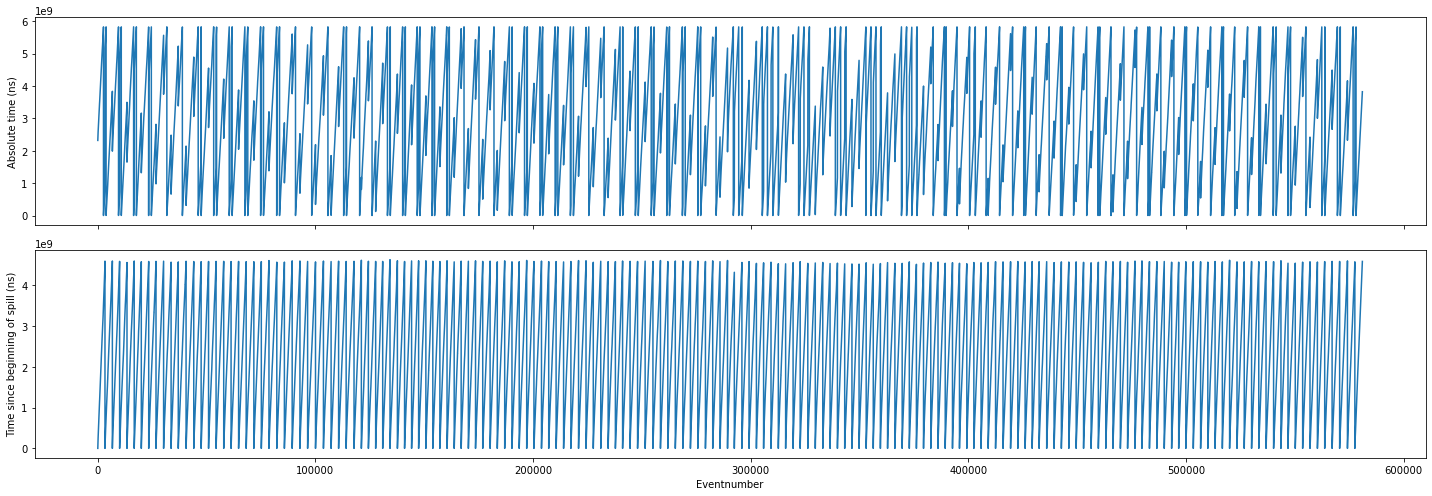

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(20, 7), sharex=True, tight_layout=True)
ax[0].plot(branches['eventCounter'], abstime)
ax[1].plot(branches['eventCounter'], spilltime)
ax[0].set(ylabel='Absolute time (ns)')
ax[1].set(xlabel='Eventnumber', ylabel='Time since beginning of spill (ns)')
fig.tight_layout()
plt.savefig('eventnumber_time', dpi=300)
plt.show()

### Plot the time between the different events

In [5]:
spillseparation = [i for i, x in enumerate(spilltime) if x == 0]

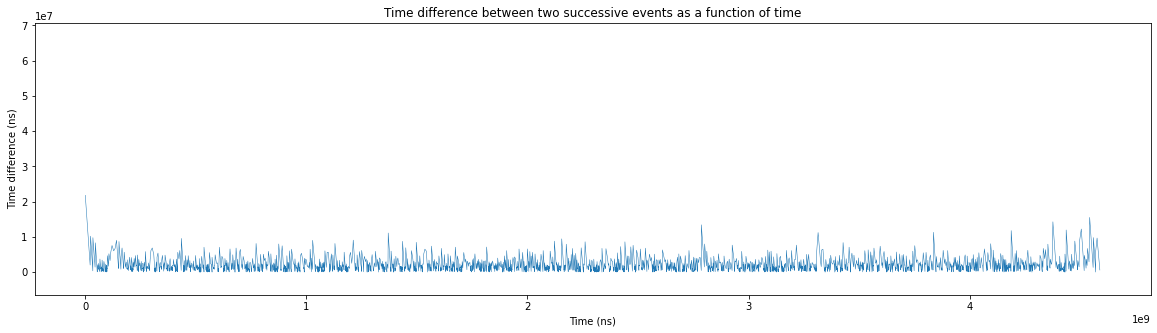

In [6]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(spilltime[:spillseparation[1]-1], np.array(spilltime[1:spillseparation[1]])-np.array(spilltime[:spillseparation[1]-1]), lw=0.5)
ax.set(ylim=(-0.1 * np.max(np.array(spilltime[1:])-np.array(spilltime[:-1])), 
             1.1 * np.max(np.array(spilltime[1:])-np.array(spilltime[:-1]))),
       xlabel='Time (ns)', ylabel='Time difference (ns)', title='Time difference between two successive events as a function of time for one spill')
plt.show()

### Plot distribution of time between events

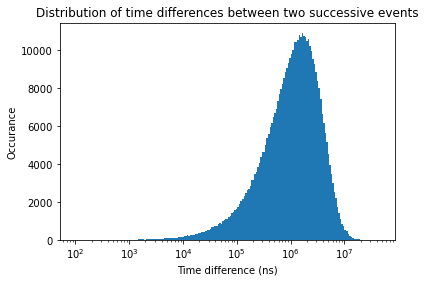

In [7]:
binmin = 100
binmax = 0.7 * np.max(np.array(spilltime[1:])-np.array(spilltime[:-1]))
binnum = 200
binsize = (binmax - binmin) // binnum
bins = np.logspace(np.log10(binmin),np.log10(binmax),binnum)

fig, ax = plt.subplots()
ax.hist(np.array(spilltime[1:])-np.array(spilltime[:-1]), bins=bins)
ax.set(xlabel='Time difference (ns)', ylabel='Occurance', title='Distribution of time differences between two successive events', xscale='log')
plt.show()

Fit an exponential to the distribution and determine the rate tau, first for all spills together and afterwards for each spill. There should be three types of spills, high rate, medium and low rate. In high rate spills we might see more influence of the charging up effect

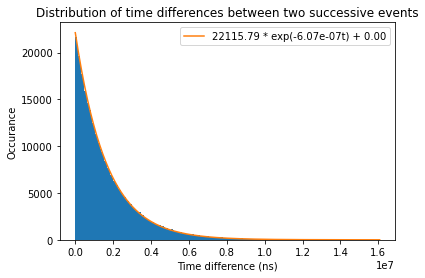

In [31]:
binmin = 100
binmax = 0.25 * np.max(np.array(spilltime[1:])-np.array(spilltime[:-1]))
binnum = 200
binsize = (binmax - binmin) // binnum
bins = np.arange(binmin, binmax, binsize)

fig, ax = plt.subplots()
fitdata, fitbins, _ = ax.hist(np.array(spilltime[1:])-np.array(spilltime[:-1]), bins=bins)
ax.set(xlabel='Time difference (ns)', ylabel='Occurance', title='Distribution of time differences between two successive events')
bincenters = fitbins[:-1] + binsize/2

myoutput = fit_exponential(bincenters, fitdata, guess=[np.max(fitdata), 0.0000001, 0])
ax.plot(np.arange(binmin, binmax, binsize), exponential(myoutput.beta, np.arange(binmin, binmax, binsize)), 
       label=f"{myoutput.beta[0]:.2f} * exp(-{myoutput.beta[1]:.2e}t) + {myoutput.beta[2]:.2f}")
plt.legend()
plt.show()

In [24]:
binmin = 100
binmax = 0.25 * np.max(np.array(spilltime[1:])-np.array(spilltime[:-1]))
binnum = 200
binsize = (binmax - binmin) // binnum
bins = np.arange(binmin, binmax, binsize)

spillseparation = [i for i, x in enumerate(spilltime) if x == 0]
table = [['Spil', 'Number of events', 'Rate']]
lengths = []

begin = 0
for index, end in enumerate(spillseparation[1:]):
    fig, ax = plt.subplots()
    fitdata, fitbins, _ = ax.hist(np.array(spilltime[begin+1:end])-np.array(spilltime[begin:end-1]), bins=bins)
    bincenters = fitbins[:-1] + binsize/2

    myoutput = fit_exponential(bincenters, fitdata, guess=[np.max(fitdata),0.0000001, 0])
    #ax.plot(np.arange(binmin, binmax, binsize), exponential(myoutput.beta, np.arange(binmin, binmax, binsize)), 
    #       label=f"{myoutput.beta[0]:.2f} * exp(-{myoutput.beta[1]:.2e}t) + {myoutput.beta[2]:.2f}")
    # ax.set(xlabel='Time difference (ns)', ylabel='Occurance', title=f'Distribution of time differences between two successive events, for spill {index}')
    #plt.legend()
    #plt.show()
    plt.close()
    
    rate = myoutput.beta[1]
    table.append([index, end-begin, rate])
    lengths.append(rate)
    
    begin = end
    
print(tabulate(table, headers='firstrow'))

  Spil    Number of events         Rate
------  ------------------  -----------
     0                2614  5.73025e-07
     1                2647  6.19857e-07
     2                2618  6.0822e-07
     3                2642  5.7352e-07
     4                2617  5.68923e-07
     5                2558  5.39191e-07
     6                2708  5.81184e-07
     7                2665  6.21532e-07
     8                2719  6.12808e-07
     9                2720  6.12545e-07
    10                2606  5.72431e-07
    11                2809  6.27354e-07
    12                2759  6.1621e-07
    13                2685  5.80777e-07
    14                2730  5.90614e-07
    15                2677  5.91215e-07
    16                2775  6.1342e-07
    17                2662  6.02151e-07
    18                2716  5.99143e-07
    19                2792  5.94644e-07
    20                2814  6.62872e-07
    21                2706  6.08931e-07
    22                2789  6.18549e-07
    

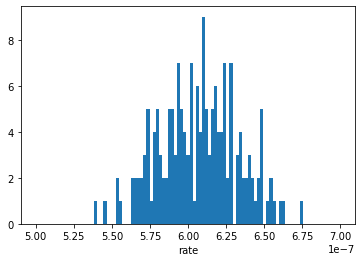

In [21]:
#minbin = 0.9*np.min(lengths)
#maxbin = 1.1*np.max(lengths)

minbin = 0.0000005
maxbin = 0.0000007
binnum = 100
bins = np.linspace(minbin, maxbin, binnum)

fig, ax = plt.subplots()

ax.hist(lengths, bins=bins)
ax.set(xlabel='rate')
plt.show()